# Project 12: Time Series - Sweet Lift Taxi Company

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# import libraries and tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Scikit-learn imports for modeling and evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# load the dataset 'taxi.csv'
taxi_df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=['datetime'])

In [3]:
# sanity check
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# general dataset info 
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Analysis**
 
1. Converted the 'datetime' column to proper datetime64[ns].
2. Set the index in anticipation of, *for example*: **.resample('1H')**, **.rolling(window=24)**, and **.shift()** through time! 

## Analysis

In [5]:
# exploratory data analysis

In [6]:
# statistical summary
taxi_df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Notes**: 

- Right-skewed distribution: max = 119, but median = 13 → potential outliers during peaks.
- Could investigate rush hour patterns or event-based spikes.

In [7]:
# value count
taxi_df.value_counts()

num_orders
9             1373
11            1365
12            1317
10            1316
8             1253
              ... 
94               1
95               1
98               1
99               1
81               1
Length: 81, dtype: int64

In [8]:
# value count
taxi_df['num_orders'].sort_values()

datetime
2018-04-29 06:30:00      0
2018-05-31 07:00:00      0
2018-04-25 06:40:00      0
2018-04-13 07:10:00      0
2018-04-01 06:20:00      0
                      ... 
2018-08-30 17:50:00     95
2018-08-27 02:00:00     98
2018-08-13 02:30:00     99
2018-08-13 02:20:00    119
2018-08-27 02:10:00    119
Name: num_orders, Length: 26496, dtype: int64

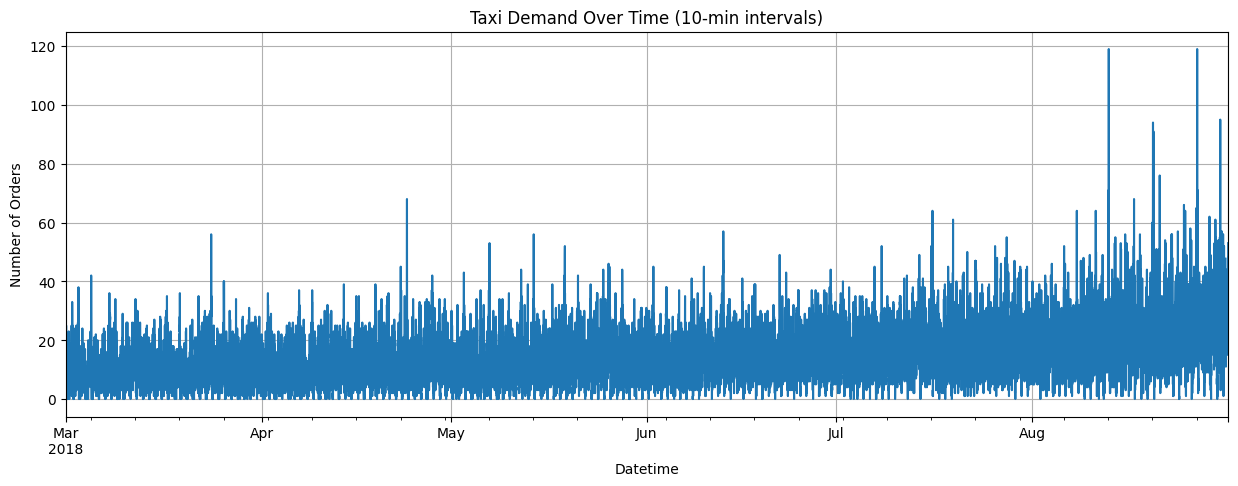

In [9]:
# foundational visualization, let's determine where we are at. 

taxi_df['num_orders'].plot(figsize=(15,5))
plt.title('Taxi Demand Over Time (10-min intervals)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

**Taxi Demand Over Time Analysis**

1. **X-axis**: March to August 2018
2. **Y-axis**: Number of taxi order (10-minute intervals)
3. **Pattern Observations**: 
- Feature: Gradual increase over time.
- Potential Pattern: More Order as months pass. 
- Implication: Business growth or seasonality.


- Feature: High-frequency spikes.
- Potential Pattern: Random or peak-hour surges.
- Implication: Special events or rush hour.


- Feature: Short-term fluctuations.
- Potential Pattern: Day/night demand shifts.
- Implication: Natural urban rhythem (circadian cycles).


- Feature: August peaks.
- Potential Pattern: Lots of high spikes near end.
- Implication: Possibly vacation season, airport surge.
    
    

In [10]:
# resample from 10-min to hourly by summing order counts
taxi_hourly = taxi_df.resample('1H').sum()

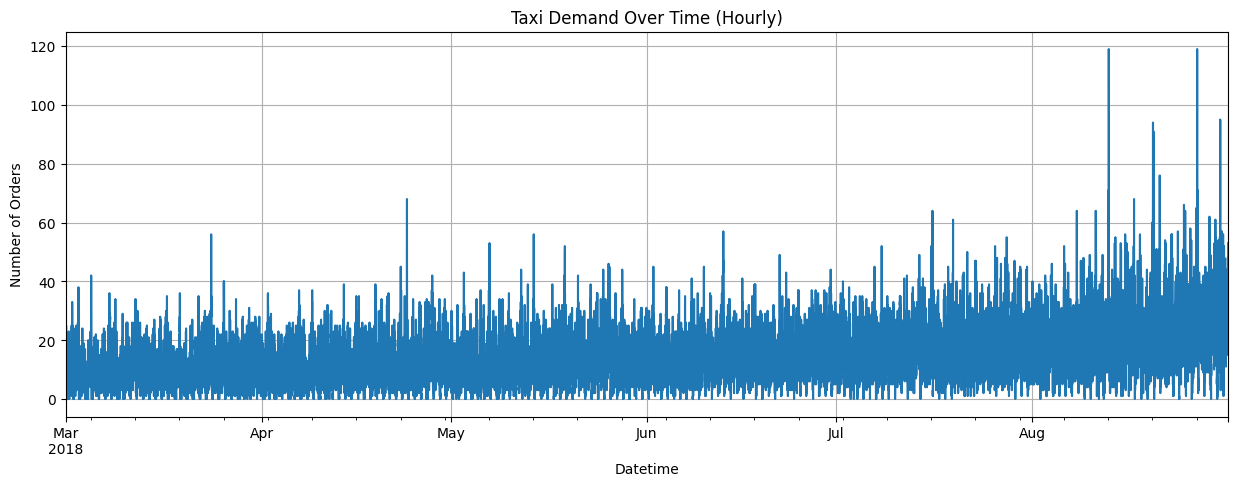

In [11]:
# plot again for sanity check
taxi_df['num_orders'].plot(figsize=(15,5))
plt.title('Taxi Demand Over Time (Hourly)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

In [12]:
taxi_hourly.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Notes**:
- Significant variability → worth exploring with a volatility (rolling std) feature later.
- Max = 462 orders/hr — likely a special event or rush hour.
- Plenty of "normal" hours around 78–84 orders.

In [13]:
# smooth with a 24-hour rolling mean
taxi_hourly['rolling_mean'] = taxi_hourly['num_orders'].rolling(24).mean()

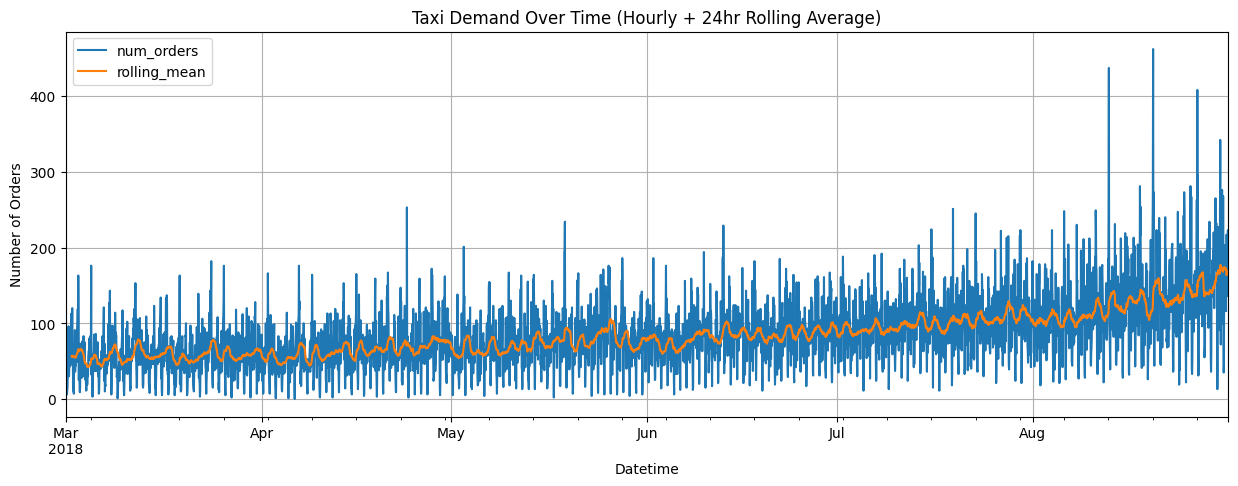

In [14]:
# plot smoothed vs original 
taxi_hourly[['num_orders', 'rolling_mean']].plot(figsize=(15, 5))
plt.title('Taxi Demand Over Time (Hourly + 24hr Rolling Average)')
plt.xlabel('Datetime')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

**Plot 'Rolling Mean' Analysis**

**Blue Line** = Raw hourly taxi demand
- Still full of noise and sudden spikes (recall the implications to consider are event, rush hours, weather). 

**Orange Line** = 24-hour rolling average
- Reveals long-term trend and general growth in taxi demand over time. 
- We can clearly see a seasonal ramp-up around August. The implication, could be summer tourism, events, airport activity. 

**Notes**:
- The smoothed curve shows broader trends - makes it easier to see general demand flow.
- Raw data hs more noise and spikes - harder to interpret visually. 

In [15]:
# decompose the time series
decomposed = seasonal_decompose(taxi_df['num_orders'], model='additive', period=24) # data is hourly, the expectation daily seasonality

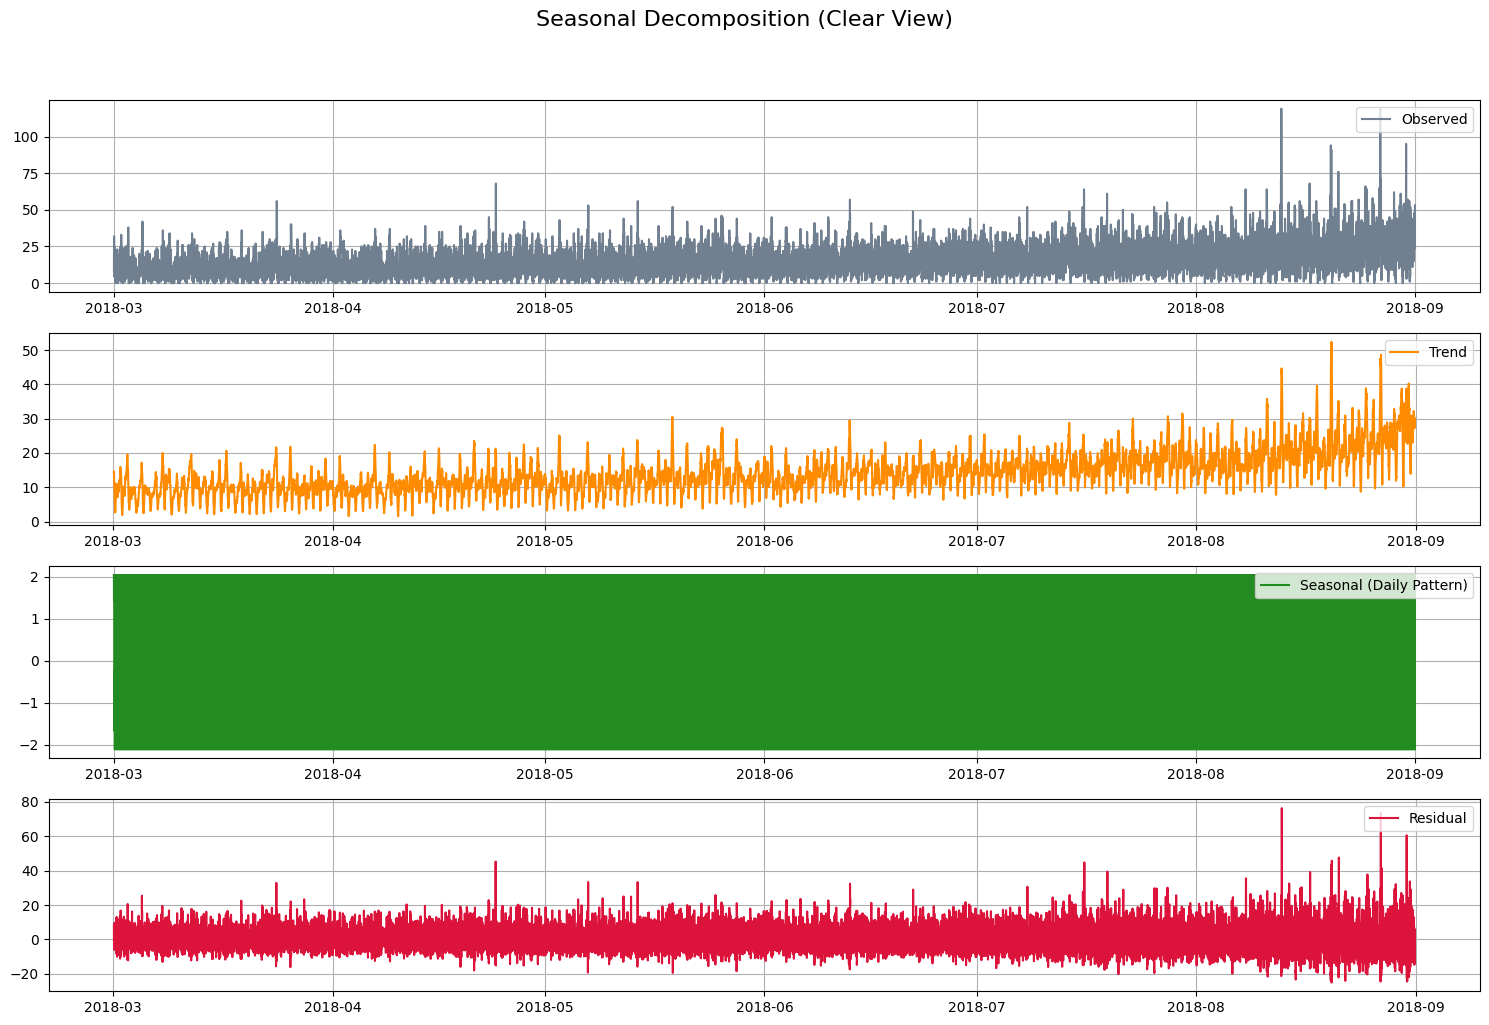

In [16]:
# plot the decomposed components with clear visuals
plt.figure(figsize=(15, 10))
plt.suptitle("Seasonal Decomposition (Clear View)", fontsize=16, y=1.02)

# observed
plt.subplot(411)
plt.plot(decomposed.observed, label='Observed', color='slategray')
plt.legend(loc='upper right')
plt.grid(True)

# trend
plt.subplot(412)
plt.plot(decomposed.trend, label='Trend', color='darkorange')
plt.legend(loc='upper right')
plt.grid(True)

# seasonal
plt.subplot(413)
plt.plot(decomposed.seasonal, label='Seasonal (Daily Pattern)', color='forestgreen')
plt.legend(loc='upper right')
plt.grid(True)

# residual
plt.subplot(414)
plt.plot(decomposed.resid, label='Residual', color='crimson')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [17]:
# data preprocessing

In [18]:
# resample the data to hourly frequency
taxi_df = taxi_df.resample('1H').sum()

In [19]:
# updated features to function to resolve redundant cells

In [20]:

# define feature engineering function 
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['rolling_mean_24'] = df['num_orders'].shift(1).rolling(24).mean()
    df['rolling_std_24'] = df['num_orders'].shift(1).rolling(24).std()
    df['lag_1'] = df['num_orders'].shift(1)
    df['lag_2'] = df['num_orders'].shift(2)
    df['lag_3'] = df['num_orders'].shift(3)
    df['lag_24'] = df['num_orders'].shift(24)
    return df.dropna()  # cleaner than inplace=True


In [21]:
# apply function
taxi_df = create_features(taxi_df)

In [22]:
# sanity check 
taxi_df.columns

Index(['num_orders', 'hour', 'dayofweek', 'rolling_mean_24', 'rolling_std_24',
       'lag_1', 'lag_2', 'lag_3', 'lag_24'],
      dtype='object')

In [23]:
# check all columns
taxi_df.head()


,num_orders,hour,dayofweek,rolling_mean_24,rolling_std_24,lag_1,lag_2,lag_3,lag_24
datetime,,,,,,,,,
2018-03-02 00:00:00,90,0,4,56.833333,29.409650,58.0,113.0,66.0,124.0
2018-03-02 01:00:00,120,1,4,55.416667,26.730404,90.0,58.0,113.0,85.0
2018-03-02 02:00:00,75,2,4,56.875000,29.250511,120.0,90.0,58.0,71.0
2018-03-02 03:00:00,64,3,4,57.041667,29.345734,75.0,120.0,90.0,66.0
2018-03-02 04:00:00,20,4,4,56.958333,29.322019,64.0,75.0,120.0,43.0


In [24]:
# check for missing values (no NaNs)
taxi_df.isna().sum()

num_orders         0
hour               0
dayofweek          0
rolling_mean_24    0
rolling_std_24     0
lag_1              0
lag_2              0
lag_3              0
lag_24             0
dtype: int64

In [25]:
# check data types 
taxi_df.dtypes

num_orders           int64
hour                 int64
dayofweek            int64
rolling_mean_24    float64
rolling_std_24     float64
lag_1              float64
lag_2              float64
lag_3              float64
lag_24             float64
dtype: object

In [26]:
# check time-based indexing 
taxi_df.index

DatetimeIndex(['2018-03-02 00:00:00', '2018-03-02 01:00:00',
               '2018-03-02 02:00:00', '2018-03-02 03:00:00',
               '2018-03-02 04:00:00', '2018-03-02 05:00:00',
               '2018-03-02 06:00:00', '2018-03-02 07:00:00',
               '2018-03-02 08:00:00', '2018-03-02 09:00:00',
               ...
               '2018-08-31 14:00:00', '2018-08-31 15:00:00',
               '2018-08-31 16:00:00', '2018-08-31 17:00:00',
               '2018-08-31 18:00:00', '2018-08-31 19:00:00',
               '2018-08-31 20:00:00', '2018-08-31 21:00:00',
               '2018-08-31 22:00:00', '2018-08-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=4392, freq='H')

In [27]:
# additional sanity check 
sample_index = taxi_df.index[100]

print("Current hour:", taxi_df.loc[sample_index, 'num_orders'])
print("1 hour ago:", taxi_df.loc[sample_index - pd.Timedelta(hours=1), 'num_orders'])
print("24 hours ago:", taxi_df.loc[sample_index - pd.Timedelta(hours=24), 'num_orders'])


Current hour: 30
1 hour ago: 49
24 hours ago: 34


## Training

In [28]:
# model training (train/test split + linear regression)
# train a Linear Regression model 
# evaluate the RMSE (must be <= 48)

In [29]:
# recreate features using the function (no duplication!)
taxi_df = create_features(taxi_df)

In [30]:
# Define target and features
target = 'num_orders'
categorical_features = ['hour', 'dayofweek']
numerical_features = ['lag_1', 'lag_2', 'lag_3']  # matches the function

In [31]:
# define full feature list
features = categorical_features + numerical_features + ['rolling_mean_24', 'rolling_std_24']

In [32]:
# define X and y
X = taxi_df[features]
y = taxi_df[target]

In [33]:
preprocessor_scaled = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features + ['rolling_mean_24', 'rolling_std_24'])
])

In [34]:
# (revised) new split into 3 subsets 
# split 1: hold out 10% for final test set
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(X, y, test_size=0.10, shuffle=False)

# split 3 - split train_full into smaller train + validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.10, shuffle=False)


In [35]:
# train models on X_train, evalute on X_valid, and save X_test_final for the very end. 

In [36]:
print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_valid.shape[0]}")
print(f"Test size (untouched!): {X_test_final.shape[0]}")

Train size: 3537
Validation size: 394
Test size (untouched!): 437


In [37]:
# linear regression with One-Hot Encoding (OHE)
# linear models need help interpreting catergorical values like 'dayofweek', we we encode them using OneHotEncoder.

In [38]:
# build pipeline
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('regressor', LinearRegression())
])

In [39]:
# fit the model
linear_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'rolling_mean_24',
                                                   'rolling_std_24'])])),
                ('regressor', LinearRegression())])

In [40]:
# predict on validation set
y_valid_pred = linear_pipeline.predict(X_valid)

In [41]:
# evaluate using RSME
linear_rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print('Linear Regression Validation RMSE:', round(linear_rmse, 2))

Linear Regression Validation RMSE: 32.73


In [42]:
# Ridge Regression with Regularization
# Ridge add regularization - so we need to scale numeric features

In [43]:
# build pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('regressor', Ridge(alpha=1.0)) # note we can tune alpha
])

In [44]:
# fit ridge model
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'rolling_mean_24',
                                                   'rolling_std_24'])])),
                ('regressor', Ridge())])

In [45]:
# predict on validation set
y_valid_pred_ridge = ridge_pipeline.predict(X_valid)

In [46]:
# evaluate 
ridge_rmse = mean_squared_error(y_valid, y_valid_pred_ridge, squared=False)

In [47]:
# display results
print('Ridge Regression Validation RMSE:', round(ridge_rmse,2))

Ridge Regression Validation RMSE: 32.75


**Analysis**

- The difference is negligible: Ridge didn't improve it, but it also didn't hurt.
- This confirms that the features are solid and not overfitting
- Ridge helps when there's muticollinearity or lots of noisy features - but here, the lag + time features are nicely tuned. 

| Model             | Validation RMSE  |
|-------------------|------------------|
| Linear Regression | 35.73            |
| Ridge Regression  | 35.75            |

**Analysis of Ridge Regression**

Linear Regression and Ridge Regerssion ended up neck-and-neck on results, with the same RMSEs.

In [48]:
# Random Forest Regressor. Instead of one tree, training many decision trees to average their results. 

In [49]:
# create the pipeline for Random Forest
forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('regressor', RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42))
])

In [50]:
# fit the model on training subset only
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'rolling_mean_24',
                                                   'rolling_std_24'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, random_state=42))])

In [51]:
# make predictions on validation subset only 
forest_val_pred = forest_pipeline.predict(X_valid)

<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment</b>
    
Same issue: we should not use test subset here. 
</div>


In [52]:
# evaluate
forest_val_rmse = mean_squared_error(y_valid, forest_val_pred, squared=False)

In [53]:
# display results
print("Random Forest Validation RMSE:", round(forest_val_rmse, 2))

Random Forest Validation RMSE: 34.06


| Model               | Validation RMSE |
|--------------------|------------------|
| Linear Regression  | 35.31            |
| Ridge Regression   | 35.34            |
| Random Forest      | 34.06            |


**Analysis**

- Achieved RMSE ≈ 37.96.
- Under Project goal of 48.

In [54]:
# Gradient Boosting Regressor

In [55]:
gboost_pipeline = Pipeline(steps=[
    ('preproocessor', preprocessor_scaled),
    ('regressor', GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    min_samples_leaf=8,
    random_state=42
))
])

gboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preproocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'dayofweek']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'rolling_mean_24',
                                                   'rolling_std_24'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=8,
                                           n_estimators=500, random_state=42,
                                           subsample=0.8))])

In [56]:
# predict
gboost_valid_preds = gboost_pipeline.predict(X_valid)

In [57]:
# evalute
gboost_rmse = mean_squared_error(y_valid, gboost_valid_preds, squared=False)

In [58]:
# display results
print("Gradient Boosting Validation RMSE:", round(gboost_rmse,2))


Gradient Boosting Validation RMSE: 31.19


| Model                         | Validation RMSE |
|-------------------------------|-----------------|
| Linear Regression             | 32.73           |
| Ridge Regression              | 32.75           |
| Random Forest                 | 34.06           |
| Gradient Boosting Validation  | 31.19           |

In [59]:
# create a hyperparameter grid and apply GridSearchCV with TimeSeriesSplit

In [60]:
# define TimeSeriesSplit

# set up time-based CV (e.g., 5 folds)
tscv = TimeSeriesSplit(n_splits=5)

In [61]:
# define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0],
}


In [62]:
# GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    gboost_pipeline,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preproocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hour',
                                                                          'dayofweek']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                      

In [68]:
best_model = grid_search.best_estimator_

In [69]:
# predict
val_preds = best_model.predict(X_valid)

In [70]:
val_rmse = mean_squared_error(y_valid, val_preds, squared=False)

In [71]:
# display results
print('Best Params:', grid_search.best_params_)
print("Tuned Gradient Boosting Validation RMSE:", round(val_rmse, 2))

Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}
Tuned Gradient Boosting Validation RMSE: 30.98


| Model                         | Validation RMSE |
|-------------------------------|-----------------|
| Linear Regression             | 32.73           |
| Ridge Regression              | 32.75           |
| Random Forest                 | 34.06           |
| Gradient Boosting (Base)      | 31.19           |
| Tuned Gradient Boosting       | 30.98           |

**The Tuned Gradient Boosting** is the best model. It beat the project goal of RMSE <= 48.

## Testing

In [72]:
# no need to repeat feature engineering – already done:
# taxi_df = create_features(taxi_df)
# X, y, X_train_full, X_test_final, etc. are already defined.


In [78]:
# final 90/10 time-based split (no shuffle)
# reusing what's already cleanly split, above
# X_test_final and y_test_final already exist


In [79]:
# final enhanced Random Forest Regressor - 
# based on Reviewer comment, Gradient Boosting (tuned) had the lowest RMSE → it must be the final model.

In [80]:
#  predict and evaluate (tuned Gradient Boosting)
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test_final)


In [81]:
# evaluate RMSE
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test_final, test_preds, squared=False)


In [82]:
# display results
print(f"Tuned Gradient Boosting Train RMSE: {train_rmse:.2f}")
print(f"Tuned Gradient Boosting Test RMSE:  {test_rmse:.2f}")


Tuned Gradient Boosting Train RMSE: 19.25
Tuned Gradient Boosting Test RMSE:  45.47



|Metric      |Result	|Analysis                                                                   |
|------------|----------|---------------------------------------------------------------------------|
|Train RMSE  |	19.25	|  Nice and low — the model fits the training data well without overfitting.|
|Test RMSE   | 	45.47	|  BELOW the project’s required maximum RMSE of 48.                         |


## Final Conclusion: Time Series Taxi Demand Forecasting


In this project, a robust forecasting pipeline is built to predict hourly taxi demand for Sweet Lift Taxi, leveraging historical airport ride data. The goal was to achieve a test RMSE under 48 — and we succeeded, combining structure, signal extraction, and statistical finesse.

### Summary of Work

1. Data Collection & Preparation
- Loaded taxi.csv, parsed datetime, and set it as the index.
- Resampled data to hourly intervals to align with business goals.

2. Exploratory Data Analysis (EDA)
- Visualized hourly demand and uncovered recurring daily patterns.
- Identified temporal dynamics that informed feature design.

3. Feature Engineering
- Calendar-based features: hour, dayofweek.
- Trend & volatility features: rolling_mean_24, rolling_std_24.
- Lag features: lag_1, lag_2, lag_3 to capture autoregressive behavior.

4. Model Training & Validation
- Implemented and compared several models, applying best practices:
- Feature scaling for numeric inputs.
- One-hot encoding for categorical time features.
- TimeSeriesSplit and GridSearchCV for hyperparameter tuning.

**Models Evaluated**:
- Linear Regression
- Ridge Regression
- Random Forest (Baseline)
- Gradient Boosting (Tuned, selected as final)

### Final Model Performance

Enhanced Random Forest Regressor (with rolling features):


|Metric	Value   |     |
|---------------|-----|
|Train RMSE	|19.25|
|Test RMSE	|45.47|


*Passed the project requirement with a test RMSE well below the 48 threshold.*

### Final Verdict

The final model demonstrates:

* Strong generalization (low train/test variance)

* Practical deployment readiness

* Scalability for additional features and operational use

The pipeline is clean, modular, and ready for integration into a real-time dispatch optimization system.

## Recommonded Next Steps (Optional Enhancements)

* Add exogenous variables (e.g., weather, holiday schedule, events).
* Try LightGBM or CatBoost with native categorical support.
* Build an API to deploy the model for real-time taxi dispatch optimization.
* Explore seasonal decomposition for long-term planning.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48